# 初始化

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
# sys.path.append('E:\GitHub\QA-abstract-and-reasoning')  # 效果同上

In [2]:
# 在google colab运行则执行以下代码
try:
    from google.colab import drive
    drive_path = '/content/drive'
    working_path = drive_path + "/My Drive/QA" # 工作路径
    drive.mount(drive_path)
    os.chdir(working_path)
    sys.path.append(working_path)  # 环境变量
    print("current working directory: ", os.getcwd())
    
    # %tensorflow_version 仅存在于 Colab
    %tensorflow_version 2.x
    print("run notebook in colab")
except:
    print("no colab")

no colab


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.set_printoptions(suppress=True)
from utils.plot import plot_attention
from utils.saveLoader import *
from utils.config import *
from layers import *
from preprocess import Preprocess
from gensim.models.word2vec import LineSentence, Word2Vec
import tensorflow as tf
# from model_layer import seq2seq_model
import time
tf.__version__

'2.0.0'

[限制gpu内存增长](https://tensorflow.google.cn/guide/gpu#limiting_gpu_memory_growth)

In [4]:
from utils.config_gpu import config_gpu
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## 加载数据

In [5]:
train_x,train_y,test_x = load_train_dataset()  # 数据集
vocab,vocab_reversed = load_vocab(VOCAB_PAD)  # vocab
embedding_matrix = np.loadtxt(EMBEDDING_MATRIX_PAD)  # 预训练层

## 设置参数

In [6]:
params = {}
params["vocab_size"] = len(vocab)
params["max_enc_len"] = train_x.shape[1]  # 260
params["max_dec_len"] = train_y.shape[1]  # 33
params["embed_size"] = embedding_matrix.shape[1]
params["enc_units"] = 256
params["attn_units"] = 10
params["dec_units"] = params["enc_units"]
params["batch_size"] = 32
params["epochs"] = 2
print(params)

{'vocab_size': 32247, 'max_enc_len': 460, 'max_dec_len': 52, 'embed_size': 300, 'enc_units': 256, 'attn_units': 10, 'dec_units': 256, 'batch_size': 32, 'epochs': 2}


## 构建训练集

In [7]:
# 取部分数据进行训练
# sample_num=256
sample_num = train_x.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((train_x[:sample_num], train_y[:sample_num])).shuffle(params["batch_size"]*2+1)
dataset = dataset.batch(params["batch_size"], drop_remainder=True)

In [8]:
steps_per_epoch = sample_num//params["batch_size"]

## 构建模型

In [9]:
from seq2seq import *
model=Seq2Seq(params)

## 保存点设置

In [10]:
from utils.config import CKPT_DIR, CKPT_PREFIX
from utils.saveLoader import del_all_files_of_dir
# del_all_files_of_dir(CKPT_DIR)
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, CKPT_DIR, max_to_keep=5)

In [11]:
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


## 训练

[SparseCategoricalCrossentropy](https://tensorflow.google.cn/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [12]:
optimizer = tf.keras.optimizers.Adam(name='Adam',learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']
unk_index=vocab['<UNK>']

def loss_function(real, pred):
    pad_mask = tf.math.equal(real, pad_index)
    unk_mask = tf.math.equal(real, unk_index)
    # <PAD> 和 <UNK> 的损失都不算
    mask = tf.math.logical_not(tf.math.logical_or(pad_mask,unk_mask))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
    # return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [13]:
pad_index,unk_index

(32245, 32246)

In [14]:
# 调试train_step()
# inp, targ = next(iter(dataset))
# pad_index=vocab['<PAD>']
# unk_index=vocab['<UNK>']
# enc_output, enc_hidden = model.call_encoder(inp)
# dec_hidden = enc_hidden
# dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
# predictions, _ = model(dec_input, dec_hidden, enc_output, targ)

In [15]:
@tf.function
def train_step(inp, targ):
    pad_index=vocab['<PAD>']
    unk_index=vocab['<UNK>']
    loss = 0
    
    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = model.call_encoder(inp)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
        
        # 逐个预测序列
        predictions, _ = model(dec_input, dec_hidden, enc_output, targ)
        # print(predictions.shape)
        batch_loss = loss_function(targ[:, 1:], predictions)
        # 
        variables = model.encoder.trainable_variables + model.decoder.trainable_variables+ model.attention.trainable_variables
    
        gradients = tape.gradient(batch_loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [16]:
epochs = params["epochs"]
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
for epoch in range(epochs):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch+1)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Latest checkpoint restored!!
Epoch 1 Batch 0 Loss 1.8663
Epoch 1 Batch 1 Loss 2.1498
Epoch 1 Batch 2 Loss 2.4501
Epoch 1 Batch 3 Loss 2.2609
Epoch 1 Batch 4 Loss 2.2598
Epoch 1 Batch 5 Loss 2.0101
Epoch 1 Batch 6 Loss 1.7021
Epoch 1 Batch 7 Loss 1.8013
Epoch 1 Batch 8 Loss 1.4737
Epoch 1 Batch 9 Loss 1.9487
Epoch 1 Batch 10 Loss 2.0281
Epoch 1 Batch 11 Loss 1.8084
Epoch 1 Batch 12 Loss 1.7119
Epoch 1 Batch 13 Loss 1.2493
Epoch 1 Batch 14 Loss 1.1742
Epoch 1 Batch 15 Loss 1.2324
Epoch 1 Batch 16 Loss 1.1538
Epoch 1 Batch 17 Loss 0.9499
Epoch 1 Batch 18 Loss 2.0083
Epoch 1 Batch 19 Loss 1.4454
Epoch 1 Batch 20 Loss 2.1571
Epoch 1 Batch 21 Loss 1.4968
Epoch 1 Batch 22 Loss 1.8610
Epoch 1 Batch 23 Loss 1.5383
Epoch 1 Batch 24 Loss 1.3607
Epoch 1 Batch 25 Loss 1.0096
Epoch 1 Batch 26 Loss 1.4371
Epoch 1 Batch 27 Loss 1.9237
Epoch 1 Batch 28 Loss 1.8917
Epoch 1 Batch 29 Loss 2.0626
Epoch 1 Batch 30 Loss 1.5595
Epoch 1 Batch 31 Loss 1.5160
Epoch 1 Batch 32 Loss 1.9559
Epoch 1 Batch 33 Loss 1.

Epoch 1 Batch 276 Loss 1.5440
Epoch 1 Batch 277 Loss 1.7686
Epoch 1 Batch 278 Loss 1.4142
Epoch 1 Batch 279 Loss 1.5678
Epoch 1 Batch 280 Loss 1.3581
Epoch 1 Batch 281 Loss 1.5941
Epoch 1 Batch 282 Loss 1.5453
Epoch 1 Batch 283 Loss 1.8031
Epoch 1 Batch 284 Loss 1.3618
Epoch 1 Batch 285 Loss 1.1664
Epoch 1 Batch 286 Loss 1.3206
Epoch 1 Batch 287 Loss 1.3170
Epoch 1 Batch 288 Loss 1.7468
Epoch 1 Batch 289 Loss 1.3844
Epoch 1 Batch 290 Loss 1.5709
Epoch 1 Batch 291 Loss 1.3833
Epoch 1 Batch 292 Loss 1.4753
Epoch 1 Batch 293 Loss 1.3892
Epoch 1 Batch 294 Loss 1.3411
Epoch 1 Batch 295 Loss 1.2639
Epoch 1 Batch 296 Loss 1.3607
Epoch 1 Batch 297 Loss 1.6602
Epoch 1 Batch 298 Loss 1.3308
Epoch 1 Batch 299 Loss 1.3078
Epoch 1 Batch 300 Loss 1.3902
Epoch 1 Batch 301 Loss 1.3139
Epoch 1 Batch 302 Loss 1.2508
Epoch 1 Batch 303 Loss 1.3354
Epoch 1 Batch 304 Loss 1.1874
Epoch 1 Batch 305 Loss 1.3966
Epoch 1 Batch 306 Loss 1.4836
Epoch 1 Batch 307 Loss 1.9200
Epoch 1 Batch 308 Loss 1.1524
Epoch 1 Ba

Epoch 1 Batch 550 Loss 1.8483
Epoch 1 Batch 551 Loss 1.5349
Epoch 1 Batch 552 Loss 1.6274
Epoch 1 Batch 553 Loss 1.4443
Epoch 1 Batch 554 Loss 1.1336
Epoch 1 Batch 555 Loss 1.5893
Epoch 1 Batch 556 Loss 1.8315
Epoch 1 Batch 557 Loss 1.4357
Epoch 1 Batch 558 Loss 1.1808
Epoch 1 Batch 559 Loss 1.2740
Epoch 1 Batch 560 Loss 1.3052
Epoch 1 Batch 561 Loss 1.6441
Epoch 1 Batch 562 Loss 1.5262
Epoch 1 Batch 563 Loss 1.4813
Epoch 1 Batch 564 Loss 1.5855
Epoch 1 Batch 565 Loss 1.2847
Epoch 1 Batch 566 Loss 1.6386
Epoch 1 Batch 567 Loss 1.3787
Epoch 1 Batch 568 Loss 1.2443
Epoch 1 Batch 569 Loss 1.6779
Epoch 1 Batch 570 Loss 1.2862
Epoch 1 Batch 571 Loss 1.4293
Epoch 1 Batch 572 Loss 1.0645
Epoch 1 Batch 573 Loss 1.2593
Epoch 1 Batch 574 Loss 1.4807
Epoch 1 Batch 575 Loss 1.4675
Epoch 1 Batch 576 Loss 1.4855
Epoch 1 Batch 577 Loss 1.8789
Epoch 1 Batch 578 Loss 1.8151
Epoch 1 Batch 579 Loss 1.5127
Epoch 1 Batch 580 Loss 1.6234
Epoch 1 Batch 581 Loss 1.5636
Epoch 1 Batch 582 Loss 1.6514
Epoch 1 Ba

Epoch 1 Batch 824 Loss 1.2456
Epoch 1 Batch 825 Loss 1.5390
Epoch 1 Batch 826 Loss 1.3318
Epoch 1 Batch 827 Loss 1.6138
Epoch 1 Batch 828 Loss 2.1526
Epoch 1 Batch 829 Loss 1.7788
Epoch 1 Batch 830 Loss 1.9052
Epoch 1 Batch 831 Loss 1.5721
Epoch 1 Batch 832 Loss 1.4429
Epoch 1 Batch 833 Loss 1.1455
Epoch 1 Batch 834 Loss 1.3538
Epoch 1 Batch 835 Loss 1.4967
Epoch 1 Batch 836 Loss 1.5857
Epoch 1 Batch 837 Loss 1.3783
Epoch 1 Batch 838 Loss 1.2951
Epoch 1 Batch 839 Loss 1.4583
Epoch 1 Batch 840 Loss 1.5072
Epoch 1 Batch 841 Loss 1.6003
Epoch 1 Batch 842 Loss 1.5926
Epoch 1 Batch 843 Loss 1.4235
Epoch 1 Batch 844 Loss 1.6488
Epoch 1 Batch 845 Loss 1.4839
Epoch 1 Batch 846 Loss 1.2685
Epoch 1 Batch 847 Loss 1.5134
Epoch 1 Batch 848 Loss 1.4114
Epoch 1 Batch 849 Loss 1.5577
Epoch 1 Batch 850 Loss 1.9209
Epoch 1 Batch 851 Loss 1.6802
Epoch 1 Batch 852 Loss 1.7605
Epoch 1 Batch 853 Loss 1.6730
Epoch 1 Batch 854 Loss 1.5168
Epoch 1 Batch 855 Loss 1.2563
Epoch 1 Batch 856 Loss 0.9809
Epoch 1 Ba

Epoch 1 Batch 1094 Loss 1.8156
Epoch 1 Batch 1095 Loss 1.8280
Epoch 1 Batch 1096 Loss 1.5252
Epoch 1 Batch 1097 Loss 1.7904
Epoch 1 Batch 1098 Loss 1.8577
Epoch 1 Batch 1099 Loss 1.6746
Epoch 1 Batch 1100 Loss 1.4745
Epoch 1 Batch 1101 Loss 1.3692
Epoch 1 Batch 1102 Loss 1.2467
Epoch 1 Batch 1103 Loss 1.6121
Epoch 1 Batch 1104 Loss 1.3872
Epoch 1 Batch 1105 Loss 1.7764
Epoch 1 Batch 1106 Loss 1.7211
Epoch 1 Batch 1107 Loss 1.8551
Epoch 1 Batch 1108 Loss 2.1083
Epoch 1 Batch 1109 Loss 1.8487
Epoch 1 Batch 1110 Loss 1.7969
Epoch 1 Batch 1111 Loss 1.4783
Epoch 1 Batch 1112 Loss 1.6389
Epoch 1 Batch 1113 Loss 1.2463
Epoch 1 Batch 1114 Loss 1.2933
Epoch 1 Batch 1115 Loss 1.8636
Epoch 1 Batch 1116 Loss 1.5483
Epoch 1 Batch 1117 Loss 1.4533
Epoch 1 Batch 1118 Loss 1.5495
Epoch 1 Batch 1119 Loss 1.2054
Epoch 1 Batch 1120 Loss 1.8496
Epoch 1 Batch 1121 Loss 2.0547
Epoch 1 Batch 1122 Loss 1.5250
Epoch 1 Batch 1123 Loss 1.0589
Epoch 1 Batch 1124 Loss 1.4628
Epoch 1 Batch 1125 Loss 1.8817
Epoch 1 

Epoch 1 Batch 1359 Loss 1.1352
Epoch 1 Batch 1360 Loss 1.5802
Epoch 1 Batch 1361 Loss 1.7513
Epoch 1 Batch 1362 Loss 1.8356
Epoch 1 Batch 1363 Loss 1.5541
Epoch 1 Batch 1364 Loss 1.4495
Epoch 1 Batch 1365 Loss 1.2035
Epoch 1 Batch 1366 Loss 1.1735
Epoch 1 Batch 1367 Loss 1.2340
Epoch 1 Batch 1368 Loss 1.9338
Epoch 1 Batch 1369 Loss 1.4079
Epoch 1 Batch 1370 Loss 1.4806
Epoch 1 Batch 1371 Loss 1.0477
Epoch 1 Batch 1372 Loss 1.5661
Epoch 1 Batch 1373 Loss 1.7980
Epoch 1 Batch 1374 Loss 1.3739
Epoch 1 Batch 1375 Loss 1.4304
Epoch 1 Batch 1376 Loss 0.8646
Epoch 1 Batch 1377 Loss 1.0964
Epoch 1 Batch 1378 Loss 1.0616
Epoch 1 Batch 1379 Loss 1.6538
Epoch 1 Batch 1380 Loss 1.9411
Epoch 1 Batch 1381 Loss 1.5274
Epoch 1 Batch 1382 Loss 1.3818
Epoch 1 Batch 1383 Loss 1.2665
Epoch 1 Batch 1384 Loss 1.6223
Epoch 1 Batch 1385 Loss 1.5606
Epoch 1 Batch 1386 Loss 1.8256
Epoch 1 Batch 1387 Loss 1.3346
Epoch 1 Batch 1388 Loss 1.2420
Epoch 1 Batch 1389 Loss 1.6190
Epoch 1 Batch 1390 Loss 1.8001
Epoch 1 

Epoch 1 Batch 1624 Loss 1.4789
Epoch 1 Batch 1625 Loss 1.8655
Epoch 1 Batch 1626 Loss 1.1516
Epoch 1 Batch 1627 Loss 1.6803
Epoch 1 Batch 1628 Loss 2.0859
Epoch 1 Batch 1629 Loss 2.0558
Epoch 1 Batch 1630 Loss 1.8345
Epoch 1 Batch 1631 Loss 1.8480
Epoch 1 Batch 1632 Loss 1.4936
Epoch 1 Batch 1633 Loss 1.6667
Epoch 1 Batch 1634 Loss 1.5459
Epoch 1 Batch 1635 Loss 1.5551
Epoch 1 Batch 1636 Loss 1.7812
Epoch 1 Batch 1637 Loss 1.6213
Epoch 1 Batch 1638 Loss 1.7921
Epoch 1 Batch 1639 Loss 1.2170
Epoch 1 Batch 1640 Loss 1.5424
Epoch 1 Batch 1641 Loss 1.5269
Epoch 1 Batch 1642 Loss 1.5838
Epoch 1 Batch 1643 Loss 1.3475
Epoch 1 Batch 1644 Loss 1.3269
Epoch 1 Batch 1645 Loss 1.1821
Epoch 1 Batch 1646 Loss 0.8505
Epoch 1 Batch 1647 Loss 1.0501
Epoch 1 Batch 1648 Loss 1.1099
Epoch 1 Batch 1649 Loss 1.2764
Epoch 1 Batch 1650 Loss 1.9281
Epoch 1 Batch 1651 Loss 1.4584
Epoch 1 Batch 1652 Loss 1.5213
Epoch 1 Batch 1653 Loss 1.5455
Epoch 1 Batch 1654 Loss 1.3004
Epoch 1 Batch 1655 Loss 1.5115
Epoch 1 

Epoch 1 Batch 1889 Loss 1.5197
Epoch 1 Batch 1890 Loss 1.1169
Epoch 1 Batch 1891 Loss 1.3447
Epoch 1 Batch 1892 Loss 1.1070
Epoch 1 Batch 1893 Loss 1.1360
Epoch 1 Batch 1894 Loss 1.2920
Epoch 1 Batch 1895 Loss 1.1477
Epoch 1 Batch 1896 Loss 1.0874
Epoch 1 Batch 1897 Loss 1.8335
Epoch 1 Batch 1898 Loss 1.6962
Epoch 1 Batch 1899 Loss 1.1230
Epoch 1 Batch 1900 Loss 1.4657
Epoch 1 Batch 1901 Loss 1.7394
Epoch 1 Batch 1902 Loss 1.6095
Epoch 1 Batch 1903 Loss 1.8246
Epoch 1 Batch 1904 Loss 1.8738
Epoch 1 Batch 1905 Loss 2.0009
Epoch 1 Batch 1906 Loss 1.7782
Epoch 1 Batch 1907 Loss 1.6768
Epoch 1 Batch 1908 Loss 1.7482
Epoch 1 Batch 1909 Loss 2.0085
Epoch 1 Batch 1910 Loss 1.7856
Epoch 1 Batch 1911 Loss 1.6930
Epoch 1 Batch 1912 Loss 2.0317
Epoch 1 Batch 1913 Loss 1.7324
Epoch 1 Batch 1914 Loss 1.6055
Epoch 1 Batch 1915 Loss 2.0855
Epoch 1 Batch 1916 Loss 1.6932
Epoch 1 Batch 1917 Loss 1.7324
Epoch 1 Batch 1918 Loss 1.4712
Epoch 1 Batch 1919 Loss 1.3633
Epoch 1 Batch 1920 Loss 1.3655
Epoch 1 

Epoch 1 Batch 2154 Loss 2.2012
Epoch 1 Batch 2155 Loss 2.1605
Epoch 1 Batch 2156 Loss 2.1517
Epoch 1 Batch 2157 Loss 1.9664
Epoch 1 Batch 2158 Loss 1.7742
Epoch 1 Batch 2159 Loss 2.2538
Epoch 1 Batch 2160 Loss 1.5250
Epoch 1 Batch 2161 Loss 1.3791
Epoch 1 Batch 2162 Loss 1.7100
Epoch 1 Batch 2163 Loss 1.6223
Epoch 1 Batch 2164 Loss 1.9940
Epoch 1 Batch 2165 Loss 2.0327
Epoch 1 Batch 2166 Loss 1.4265
Epoch 1 Batch 2167 Loss 1.5706
Epoch 1 Batch 2168 Loss 1.1408
Epoch 1 Batch 2169 Loss 1.2639
Epoch 1 Batch 2170 Loss 1.1899
Epoch 1 Batch 2171 Loss 1.6786
Epoch 1 Batch 2172 Loss 1.5990
Epoch 1 Batch 2173 Loss 1.3821
Epoch 1 Batch 2174 Loss 1.4915
Epoch 1 Batch 2175 Loss 1.4931
Epoch 1 Batch 2176 Loss 1.3331
Epoch 1 Batch 2177 Loss 1.5086
Epoch 1 Batch 2178 Loss 1.4199
Epoch 1 Batch 2179 Loss 1.8268
Epoch 1 Batch 2180 Loss 1.9522
Epoch 1 Batch 2181 Loss 1.8814
Epoch 1 Batch 2182 Loss 1.8527
Epoch 1 Batch 2183 Loss 1.8298
Epoch 1 Batch 2184 Loss 1.6488
Epoch 1 Batch 2185 Loss 1.5617
Epoch 1 

Epoch 1 Batch 2419 Loss 1.2025
Epoch 1 Batch 2420 Loss 1.0476
Epoch 1 Batch 2421 Loss 1.0207
Epoch 1 Batch 2422 Loss 1.1045
Epoch 1 Batch 2423 Loss 1.1764
Epoch 1 Batch 2424 Loss 1.2904
Epoch 1 Batch 2425 Loss 1.2455
Epoch 1 Batch 2426 Loss 1.7296
Epoch 1 Batch 2427 Loss 1.5582
Epoch 1 Batch 2428 Loss 1.3186
Epoch 1 Batch 2429 Loss 1.2405
Epoch 1 Batch 2430 Loss 1.0278
Epoch 1 Batch 2431 Loss 1.2002
Epoch 1 Batch 2432 Loss 1.3183
Epoch 1 Batch 2433 Loss 1.2335
Epoch 1 Batch 2434 Loss 1.5760
Epoch 1 Batch 2435 Loss 1.3178
Epoch 1 Batch 2436 Loss 1.0753
Epoch 1 Batch 2437 Loss 1.3024
Epoch 1 Batch 2438 Loss 1.4182
Epoch 1 Batch 2439 Loss 1.2104
Epoch 1 Batch 2440 Loss 1.1338
Epoch 1 Batch 2441 Loss 1.2059
Epoch 1 Batch 2442 Loss 1.0450
Epoch 1 Batch 2443 Loss 1.1845
Epoch 1 Batch 2444 Loss 1.4556
Epoch 1 Batch 2445 Loss 1.0919
Epoch 1 Batch 2446 Loss 1.3997
Epoch 1 Batch 2447 Loss 1.2942
Epoch 1 Batch 2448 Loss 1.2487
Epoch 1 Batch 2449 Loss 0.8732
Epoch 1 Batch 2450 Loss 1.6726
Epoch 1 

Epoch 2 Batch 97 Loss 1.6182
Epoch 2 Batch 98 Loss 1.6041
Epoch 2 Batch 99 Loss 1.5094
Epoch 2 Batch 100 Loss 2.2626
Epoch 2 Batch 101 Loss 1.8873
Epoch 2 Batch 102 Loss 1.5891
Epoch 2 Batch 103 Loss 1.2578
Epoch 2 Batch 104 Loss 1.7847
Epoch 2 Batch 105 Loss 1.7154
Epoch 2 Batch 106 Loss 1.8129
Epoch 2 Batch 107 Loss 1.7765
Epoch 2 Batch 108 Loss 1.9441
Epoch 2 Batch 109 Loss 1.2709
Epoch 2 Batch 110 Loss 1.1548
Epoch 2 Batch 111 Loss 1.0493
Epoch 2 Batch 112 Loss 1.2862
Epoch 2 Batch 113 Loss 0.9576
Epoch 2 Batch 114 Loss 2.0569
Epoch 2 Batch 115 Loss 1.4132
Epoch 2 Batch 116 Loss 1.2986
Epoch 2 Batch 117 Loss 1.1718
Epoch 2 Batch 118 Loss 1.3442
Epoch 2 Batch 119 Loss 1.3577
Epoch 2 Batch 120 Loss 1.4960
Epoch 2 Batch 121 Loss 1.4053
Epoch 2 Batch 122 Loss 1.4516
Epoch 2 Batch 123 Loss 1.3341
Epoch 2 Batch 124 Loss 1.1421
Epoch 2 Batch 125 Loss 1.3090
Epoch 2 Batch 126 Loss 1.1636
Epoch 2 Batch 127 Loss 1.3558
Epoch 2 Batch 128 Loss 1.0975
Epoch 2 Batch 129 Loss 1.2765
Epoch 2 Batch

Epoch 2 Batch 371 Loss 1.4622
Epoch 2 Batch 372 Loss 1.0708
Epoch 2 Batch 373 Loss 1.5170
Epoch 2 Batch 374 Loss 1.1628
Epoch 2 Batch 375 Loss 1.0836
Epoch 2 Batch 376 Loss 0.8970
Epoch 2 Batch 377 Loss 1.2784
Epoch 2 Batch 378 Loss 1.1499
Epoch 2 Batch 379 Loss 1.1031
Epoch 2 Batch 380 Loss 1.0623
Epoch 2 Batch 381 Loss 1.1517
Epoch 2 Batch 382 Loss 1.0839
Epoch 2 Batch 383 Loss 1.2510
Epoch 2 Batch 384 Loss 1.6249
Epoch 2 Batch 385 Loss 1.2761
Epoch 2 Batch 386 Loss 1.2438
Epoch 2 Batch 387 Loss 1.6326
Epoch 2 Batch 388 Loss 1.3928
Epoch 2 Batch 389 Loss 1.4927
Epoch 2 Batch 390 Loss 1.4364
Epoch 2 Batch 391 Loss 1.3137
Epoch 2 Batch 392 Loss 1.5833
Epoch 2 Batch 393 Loss 1.3795
Epoch 2 Batch 394 Loss 1.1968
Epoch 2 Batch 395 Loss 1.2835
Epoch 2 Batch 396 Loss 1.0305
Epoch 2 Batch 397 Loss 1.0530
Epoch 2 Batch 398 Loss 1.3554
Epoch 2 Batch 399 Loss 1.6096
Epoch 2 Batch 400 Loss 1.4498
Epoch 2 Batch 401 Loss 1.4452
Epoch 2 Batch 402 Loss 0.9054
Epoch 2 Batch 403 Loss 0.9686
Epoch 2 Ba

Epoch 2 Batch 645 Loss 1.0944
Epoch 2 Batch 646 Loss 1.4771
Epoch 2 Batch 647 Loss 1.5985
Epoch 2 Batch 648 Loss 1.4373
Epoch 2 Batch 649 Loss 1.2718
Epoch 2 Batch 650 Loss 1.4492
Epoch 2 Batch 651 Loss 1.5372
Epoch 2 Batch 652 Loss 1.6630
Epoch 2 Batch 653 Loss 1.4802
Epoch 2 Batch 654 Loss 1.8290
Epoch 2 Batch 655 Loss 1.8825
Epoch 2 Batch 656 Loss 1.4010
Epoch 2 Batch 657 Loss 1.8057
Epoch 2 Batch 658 Loss 1.3142
Epoch 2 Batch 659 Loss 1.4336
Epoch 2 Batch 660 Loss 1.3816
Epoch 2 Batch 661 Loss 1.6376
Epoch 2 Batch 662 Loss 1.7584
Epoch 2 Batch 663 Loss 1.3431
Epoch 2 Batch 664 Loss 1.6090
Epoch 2 Batch 665 Loss 1.4498
Epoch 2 Batch 666 Loss 1.4750
Epoch 2 Batch 667 Loss 1.9451
Epoch 2 Batch 668 Loss 1.4116
Epoch 2 Batch 669 Loss 1.2136
Epoch 2 Batch 670 Loss 1.1535
Epoch 2 Batch 671 Loss 1.4172
Epoch 2 Batch 672 Loss 1.3739
Epoch 2 Batch 673 Loss 1.2413
Epoch 2 Batch 674 Loss 1.5932
Epoch 2 Batch 675 Loss 1.2291
Epoch 2 Batch 676 Loss 1.3080
Epoch 2 Batch 677 Loss 1.2391
Epoch 2 Ba

Epoch 2 Batch 919 Loss 1.5195
Epoch 2 Batch 920 Loss 1.6950
Epoch 2 Batch 921 Loss 1.3412
Epoch 2 Batch 922 Loss 1.3233
Epoch 2 Batch 923 Loss 1.3857
Epoch 2 Batch 924 Loss 1.6187
Epoch 2 Batch 925 Loss 1.8711
Epoch 2 Batch 926 Loss 1.7423
Epoch 2 Batch 927 Loss 1.4549
Epoch 2 Batch 928 Loss 1.5702
Epoch 2 Batch 929 Loss 1.6510
Epoch 2 Batch 930 Loss 1.7095
Epoch 2 Batch 931 Loss 1.4418
Epoch 2 Batch 932 Loss 1.7578
Epoch 2 Batch 933 Loss 1.5698
Epoch 2 Batch 934 Loss 1.8593
Epoch 2 Batch 935 Loss 1.8819
Epoch 2 Batch 936 Loss 2.0255
Epoch 2 Batch 937 Loss 1.4815
Epoch 2 Batch 938 Loss 1.7458
Epoch 2 Batch 939 Loss 1.1706
Epoch 2 Batch 940 Loss 1.5015
Epoch 2 Batch 941 Loss 1.2777
Epoch 2 Batch 942 Loss 1.1329
Epoch 2 Batch 943 Loss 1.1036
Epoch 2 Batch 944 Loss 1.2800
Epoch 2 Batch 945 Loss 1.4831
Epoch 2 Batch 946 Loss 1.2727
Epoch 2 Batch 947 Loss 1.5333
Epoch 2 Batch 948 Loss 1.4310
Epoch 2 Batch 949 Loss 1.3628
Epoch 2 Batch 950 Loss 1.5888
Epoch 2 Batch 951 Loss 1.4372
Epoch 2 Ba

Epoch 2 Batch 1186 Loss 1.3029
Epoch 2 Batch 1187 Loss 1.4385
Epoch 2 Batch 1188 Loss 1.5466
Epoch 2 Batch 1189 Loss 1.8482
Epoch 2 Batch 1190 Loss 1.5022
Epoch 2 Batch 1191 Loss 1.5008
Epoch 2 Batch 1192 Loss 1.5859
Epoch 2 Batch 1193 Loss 1.6000
Epoch 2 Batch 1194 Loss 1.4313
Epoch 2 Batch 1195 Loss 1.4154
Epoch 2 Batch 1196 Loss 1.6173
Epoch 2 Batch 1197 Loss 1.5120
Epoch 2 Batch 1198 Loss 1.1579
Epoch 2 Batch 1199 Loss 0.9406
Epoch 2 Batch 1200 Loss 1.4529
Epoch 2 Batch 1201 Loss 1.2493
Epoch 2 Batch 1202 Loss 1.4956
Epoch 2 Batch 1203 Loss 1.3488
Epoch 2 Batch 1204 Loss 1.3563
Epoch 2 Batch 1205 Loss 1.0777
Epoch 2 Batch 1206 Loss 1.0812
Epoch 2 Batch 1207 Loss 1.3998
Epoch 2 Batch 1208 Loss 1.4075
Epoch 2 Batch 1209 Loss 1.2436
Epoch 2 Batch 1210 Loss 1.2544
Epoch 2 Batch 1211 Loss 1.7849
Epoch 2 Batch 1212 Loss 1.3904
Epoch 2 Batch 1213 Loss 1.5119
Epoch 2 Batch 1214 Loss 1.6995
Epoch 2 Batch 1215 Loss 1.3778
Epoch 2 Batch 1216 Loss 1.5808
Epoch 2 Batch 1217 Loss 1.2941
Epoch 2 

Epoch 2 Batch 1451 Loss 1.4864
Epoch 2 Batch 1452 Loss 1.3495
Epoch 2 Batch 1453 Loss 1.1952
Epoch 2 Batch 1454 Loss 1.0865
Epoch 2 Batch 1455 Loss 1.5571
Epoch 2 Batch 1456 Loss 1.3434
Epoch 2 Batch 1457 Loss 1.4898
Epoch 2 Batch 1458 Loss 1.0867
Epoch 2 Batch 1459 Loss 0.8436
Epoch 2 Batch 1460 Loss 0.6170
Epoch 2 Batch 1461 Loss 0.8170
Epoch 2 Batch 1462 Loss 0.8679
Epoch 2 Batch 1463 Loss 1.1776
Epoch 2 Batch 1464 Loss 1.4141
Epoch 2 Batch 1465 Loss 1.0884
Epoch 2 Batch 1466 Loss 1.4717
Epoch 2 Batch 1467 Loss 1.4323
Epoch 2 Batch 1468 Loss 1.6786
Epoch 2 Batch 1469 Loss 1.6143
Epoch 2 Batch 1470 Loss 1.3900
Epoch 2 Batch 1471 Loss 1.3380
Epoch 2 Batch 1472 Loss 1.6142
Epoch 2 Batch 1473 Loss 1.4236
Epoch 2 Batch 1474 Loss 1.7204
Epoch 2 Batch 1475 Loss 1.4536
Epoch 2 Batch 1476 Loss 1.3166
Epoch 2 Batch 1477 Loss 1.2926
Epoch 2 Batch 1478 Loss 1.3564
Epoch 2 Batch 1479 Loss 1.0983
Epoch 2 Batch 1480 Loss 1.4029
Epoch 2 Batch 1481 Loss 1.2123
Epoch 2 Batch 1482 Loss 1.6596
Epoch 2 

Epoch 2 Batch 1716 Loss 1.5242
Epoch 2 Batch 1717 Loss 1.6724
Epoch 2 Batch 1718 Loss 1.4278
Epoch 2 Batch 1719 Loss 1.3962
Epoch 2 Batch 1720 Loss 1.4376
Epoch 2 Batch 1721 Loss 1.6458
Epoch 2 Batch 1722 Loss 1.1853
Epoch 2 Batch 1723 Loss 1.2646
Epoch 2 Batch 1724 Loss 1.3161
Epoch 2 Batch 1725 Loss 1.3520
Epoch 2 Batch 1726 Loss 1.2186
Epoch 2 Batch 1727 Loss 1.3318
Epoch 2 Batch 1728 Loss 1.8200
Epoch 2 Batch 1729 Loss 1.4620
Epoch 2 Batch 1730 Loss 1.6025
Epoch 2 Batch 1731 Loss 1.4858
Epoch 2 Batch 1732 Loss 1.3628
Epoch 2 Batch 1733 Loss 1.1216
Epoch 2 Batch 1734 Loss 1.3208
Epoch 2 Batch 1735 Loss 0.8349
Epoch 2 Batch 1736 Loss 1.3437
Epoch 2 Batch 1737 Loss 2.0078
Epoch 2 Batch 1738 Loss 1.8414
Epoch 2 Batch 1739 Loss 1.4991
Epoch 2 Batch 1740 Loss 1.6069
Epoch 2 Batch 1741 Loss 1.3912
Epoch 2 Batch 1742 Loss 1.0484
Epoch 2 Batch 1743 Loss 1.2990
Epoch 2 Batch 1744 Loss 0.9354
Epoch 2 Batch 1745 Loss 1.3505
Epoch 2 Batch 1746 Loss 1.4199
Epoch 2 Batch 1747 Loss 1.2887
Epoch 2 

Epoch 2 Batch 1981 Loss 1.5554
Epoch 2 Batch 1982 Loss 1.1981
Epoch 2 Batch 1983 Loss 1.2047
Epoch 2 Batch 1984 Loss 1.8265
Epoch 2 Batch 1985 Loss 1.4064
Epoch 2 Batch 1986 Loss 1.6276
Epoch 2 Batch 1987 Loss 1.8031
Epoch 2 Batch 1988 Loss 1.3141
Epoch 2 Batch 1989 Loss 1.2709
Epoch 2 Batch 1990 Loss 1.1525
Epoch 2 Batch 1991 Loss 1.0929
Epoch 2 Batch 1992 Loss 1.3296
Epoch 2 Batch 1993 Loss 1.3252
Epoch 2 Batch 1994 Loss 1.3984
Epoch 2 Batch 1995 Loss 1.7305
Epoch 2 Batch 1996 Loss 1.2378
Epoch 2 Batch 1997 Loss 1.2079
Epoch 2 Batch 1998 Loss 1.5004
Epoch 2 Batch 1999 Loss 1.2709
Epoch 2 Batch 2000 Loss 1.7426
Epoch 2 Batch 2001 Loss 1.5319
Epoch 2 Batch 2002 Loss 1.9127
Epoch 2 Batch 2003 Loss 1.7324
Epoch 2 Batch 2004 Loss 1.6992
Epoch 2 Batch 2005 Loss 1.8362
Epoch 2 Batch 2006 Loss 1.7490
Epoch 2 Batch 2007 Loss 1.7059
Epoch 2 Batch 2008 Loss 1.6553
Epoch 2 Batch 2009 Loss 1.6740
Epoch 2 Batch 2010 Loss 1.5070
Epoch 2 Batch 2011 Loss 1.9449
Epoch 2 Batch 2012 Loss 1.6693
Epoch 2 

Epoch 2 Batch 2246 Loss 1.0969
Epoch 2 Batch 2247 Loss 1.2955
Epoch 2 Batch 2248 Loss 1.5963
Epoch 2 Batch 2249 Loss 1.0586
Epoch 2 Batch 2250 Loss 1.1187
Epoch 2 Batch 2251 Loss 1.4445
Epoch 2 Batch 2252 Loss 1.3300
Epoch 2 Batch 2253 Loss 1.2510
Epoch 2 Batch 2254 Loss 1.3019
Epoch 2 Batch 2255 Loss 1.4228
Epoch 2 Batch 2256 Loss 1.4412
Epoch 2 Batch 2257 Loss 1.5274
Epoch 2 Batch 2258 Loss 1.8393
Epoch 2 Batch 2259 Loss 1.3563
Epoch 2 Batch 2260 Loss 1.1092
Epoch 2 Batch 2261 Loss 1.4138
Epoch 2 Batch 2262 Loss 1.2597
Epoch 2 Batch 2263 Loss 1.3453
Epoch 2 Batch 2264 Loss 1.2634
Epoch 2 Batch 2265 Loss 1.2496
Epoch 2 Batch 2266 Loss 1.1436
Epoch 2 Batch 2267 Loss 1.2896
Epoch 2 Batch 2268 Loss 1.5251
Epoch 2 Batch 2269 Loss 1.3879
Epoch 2 Batch 2270 Loss 0.9943
Epoch 2 Batch 2271 Loss 1.1172
Epoch 2 Batch 2272 Loss 1.4483
Epoch 2 Batch 2273 Loss 1.2450
Epoch 2 Batch 2274 Loss 1.7002
Epoch 2 Batch 2275 Loss 1.3888
Epoch 2 Batch 2276 Loss 1.2080
Epoch 2 Batch 2277 Loss 1.6732
Epoch 2 

Epoch 2 Batch 2511 Loss 1.3213
Epoch 2 Batch 2512 Loss 1.6809
Epoch 2 Batch 2513 Loss 1.2379
Epoch 2 Batch 2514 Loss 1.3623
Epoch 2 Batch 2515 Loss 1.5162
Epoch 2 Batch 2516 Loss 0.9690
Epoch 2 Batch 2517 Loss 1.1781
Epoch 2 Batch 2518 Loss 1.0189
Epoch 2 Batch 2519 Loss 1.3732
Epoch 2 Batch 2520 Loss 1.9103
Epoch 2 Batch 2521 Loss 1.0557
Epoch 2 Batch 2522 Loss 1.6044
Epoch 2 Batch 2523 Loss 1.4144
Epoch 2 Batch 2524 Loss 1.4184
Epoch 2 Batch 2525 Loss 1.3322
Epoch 2 Batch 2526 Loss 1.0692
Epoch 2 Batch 2527 Loss 1.8067
Epoch 2 Batch 2528 Loss 1.8605
Epoch 2 Batch 2529 Loss 1.5943
Epoch 2 Batch 2530 Loss 1.2700
Epoch 2 Batch 2531 Loss 1.4105
Epoch 2 Batch 2532 Loss 1.2552
Epoch 2 Batch 2533 Loss 1.1499
Epoch 2 Batch 2534 Loss 1.2992
Epoch 2 Batch 2535 Loss 1.2930
Epoch 2 Batch 2536 Loss 1.2260
Epoch 2 Batch 2537 Loss 1.2689
Epoch 2 Batch 2538 Loss 1.4105
Epoch 2 Batch 2539 Loss 1.2233
Epoch 2 Batch 2540 Loss 1.2217
Epoch 2 Batch 2541 Loss 1.3426
Epoch 2 Batch 2542 Loss 1.0972
Epoch 2 

## 载入模型

In [17]:
# 如果检查点存在，则恢复最新的检查点。
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


In [18]:
def evaluate(model,inputs):
    attention_plot = np.zeros((params["max_dec_len"], params["max_enc_len"]))
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, params["enc_units"]))]
    enc_output, enc_hidden = model.encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)

    for t in range(params["max_dec_len"]):
        
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab_reversed[predicted_id] + ' '
        if vocab_reversed[predicted_id] == '<STOP>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [19]:
def translate(sentence):
    st = preproc.sentence_proc(sentence)
    sentence = preproc.sentence_proc_eval(sentence,params["max_enc_len"]-2,vocab)
    result, attention_plot = evaluate(model,sentence)

    print('Input: %s' % (st))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(st.split(' '))]
    plot_attention(attention_plot, st.split(' '), result.split(' '))

In [20]:
sentence = '方向机重，助力泵，方向机都换了还是一样'
preproc = Preprocess()
preproc.sentence_proc(sentence)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Light\AppData\Local\Temp\jieba.cache


创建一个预处理器


Loading model cost 0.684 seconds.
Prefix dict has been built succesfully.


'方向机 重 ， 助力 泵 ， 方向机 都 换 了 还是 一样'

In [21]:
# import matplotlib as mpl
# mpl.rcParams['font.family'] = 'STSong'  # 显示中文

Input: 方向机 重 ， 助力 泵 ， 方向机 都 换 了 还是 一样
Predicted translation: 你好 ， 根据 描述 情况 分析 应该 是 方向机 的 方向机 的 问题 ， 需要 更换 方向机 的 问题 ， 需要 更换 方向机 的 问题 ， 需要 更换 方向机 的 问题 ， 需要 更换 方向机 的 问题 ， 需要 更换 方向机 的 问题 ， 需要 更换 方向机 的 问题 ， 需要 更换 


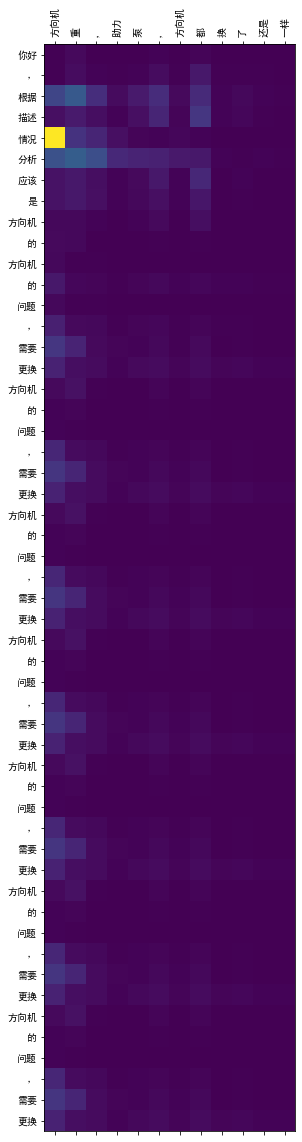

In [24]:
translate(sentence)

In [25]:
# 下半部分
assert False

AssertionError: 

In [26]:
def batch_predict(inps):
    # 判断输入长度
    batch_size=len(inps)
    # 开辟结果存储list
    preidicts=[''] * batch_size
    
    inps = tf.convert_to_tensor(inps)
    # 0. 初始化隐藏层输入
    hidden = [tf.zeros((batch_size, params["enc_units"]))]
    # 1. 构建encoder
    enc_output, enc_hidden = model.encoder(inps, hidden)
    # 2. 复制
    dec_hidden = enc_hidden
    # 3. <START> * BATCH_SIZE 
    dec_input = tf.expand_dims([vocab['<START>']] * batch_size, 1)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)
    # Teacher forcing - feeding the target as the next input
    for t in range(params["max_dec_len"]):
        # 计算上下文
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        # 单步预测
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)
        
        # id转换 贪婪搜索
        predicted_ids = tf.argmax(predictions,axis=1).numpy()
        
        
        for index,predicted_id in enumerate(predicted_ids):
            preidicts[index]+= vocab_reversed[predicted_id] + ' '
        
        # using teacher forcing
        dec_input = tf.expand_dims(predicted_ids, 1)

    results=[]
    for preidict in preidicts:
        # 去掉句子前后空格
        preidict=preidict.strip()
        # 句子小于max len就结束了 截断
        if '<STOP>' in preidict:
            # 截断stop
            preidict=preidict[:preidict.index('<STOP>')]
        # 保存结果
        results.append(preidict)
    return results

In [ ]:
# 测试代码
# ds = iter(dataset)
# x,y = ds.next()
# batch_predict(x)

In [27]:
from tqdm import tqdm
import math

In [28]:
def model_predict(data_X, batch_size):
    # 存储结果
    results=[]
    # 样本数量
    sample_size=len(data_X)
    # batch 操作轮数 math.ceil向上取整 小数 +1
    # 因为最后一个batch可能不足一个batch size 大小 ,但是依然需要计算  
    steps_epoch = math.ceil(sample_size/batch_size)
    # [0,steps_epoch)
    for i in tqdm(range(steps_epoch)):
        batch_data = data_X[i*batch_size:(i+1)*batch_size]
        results+=batch_predict(batch_data)
    return results

In [31]:
%%time
# 128 或 256
results=model_predict(test_x,batch_size=128)

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [02:23<00:00,  1.09it/s]

Wall time: 2min 23s


In [33]:
# 读入提交数据
test_df=pd.read_csv(TEST_DATA)
test_df.head()

,QID,Brand,Model,Question,Dialogue
0,Q1,大众(进口),高尔夫(进口),我的帕萨特烧机油怎么办怎么办？,技师说：你好，请问你的车跑了多少公里了，如果在保修期内，可以到当地的4店里面进行检查维修。如...
1,Q2,一汽-大众奥迪,奥迪A6,修一下多少钱是换还是修,技师说：你好师傅！抛光处理一下就好了！50元左右就好了，希望能够帮到你！祝你生活愉快！
2,Q3,上汽大众,帕萨特,帕萨特领域 喇叭坏了 店里说方向盘里线坏了 换一根两三百不等 感觉太贵,技师说：你好，气囊油丝坏了吗，这个价格不贵。可以更换。
3,Q4,南京菲亚特,派力奥,发动机漏气会有什么征兆？,技师说：你好！一：发动机没力，并伴有“啪啪”的漏气声音。二：发动机没力，并伴有排气管冒黑烟。...
4,Q5,东风本田,思铂睿,请问 那天右后胎扎了订，补了胎后跑高速80多开始有点抖，110时速以上抖动明显，以为是未做动...,技师说：你好师傅！可能前轮平衡快脱落或者不平衡造成的！建议前轮做一下动平衡就好了！希望能够帮...


In [35]:
def submit_proc(sentence):
    sentence=sentence.lstrip(' ，！。？-.')
    sentence=sentence.replace(' ','')
    if sentence=='':
        sentence='随时联系'
    return sentence

In [36]:
for idx,result in enumerate(results):
    if result=='':print(idx)

In [37]:
# 赋值结果
test_df['Prediction']=results
#　提取ID和预测结果两列
test_df=test_df[['QID','Prediction']]

In [38]:
test_df.head()

,QID,Prediction
0,Q1,建议 到 4S店 进行 维修
1,Q2,你好 ， 根据 你 的 描述 ， 根据 你 的 描述 ， 根据 你 的 描述 ， 根据 你 ...
2,Q3,这个 是 气囊 游丝 的 问题 ， 可以 更换 。
3,Q4,发动机 有 轻微 的 。
4,Q5,建议 做下 四轮 定位


In [39]:
test_df['Prediction']=test_df['Prediction'].apply(submit_proc)

In [40]:
test_df.head()

,QID,Prediction
0,Q1,建议到4S店进行维修
1,Q2,你好，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根...
2,Q3,这个是气囊游丝的问题，可以更换。
3,Q4,发动机有轻微的。
4,Q5,建议做下四轮定位


In [ ]:
def del_repeat(sentence):
    pass

In [44]:
import os
from utils.config import RESULT_PATH

In [48]:
# 保存结果.
result_save_path = os.path.join(RESULT_PATH, "my_first_result.csv")
test_df.to_csv(result_save_path, index=None,sep=',')

In [50]:
test_df2=pd.read_csv(result_save_path)
# 查看格式
test_df2.head(10)

,QID,Prediction
0,Q1,建议到4S店进行维修
1,Q2,你好，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根...
2,Q3,这个是气囊游丝的问题，可以更换。
3,Q4,发动机有轻微的。
4,Q5,建议做下四轮定位
5,Q6,你好，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根据你的描述，根...
6,Q7,防冻液可以添加的，可以添加的，可以添加的，可以添加的，可以添加的，可以添加的，可以添加的，可...
7,Q8,这种情况是机油的机油的机油，如果是机油的机油的机油，如果是机油的机油的机油，如果是机油的机油...
8,Q9,轮胎侧面有裂纹，这个轮胎的轮胎的轮胎的轮胎的轮胎的轮胎的轮胎的轮胎的轮胎的轮胎的轮胎的轮胎的...
9,Q10,这种情况有可能是由于发动机内部的声音，所以会有声音，所以会有声音，所以会有声音，所以会有声音...
